In [1]:
import numpy as np
from astropy.io import fits
from astropy import units as u
from astropy.wcs import WCS
import radio_beam
from spectral_cube import SpectralCube
from reproject import reproject_exact
import matplotlib.pyplot as plt
#from matplotlib.colors import ListedColormap

In [2]:
path = '/vol/aibn1081/data1/brodriguez/'

In [ ]:
CO_cube = SpectralCube.read(path+'UGC12250_7m_co21_pbcor.fits')
CO_cube = CO_cube.minimal_subcube()
if CO_cube.unit == 'Jy/beam':
    CO_cube = CO_cube.to(u.K)
if CO_cube.header['CUNIT3'] == 'm/s':
    CO_cube = CO_cube.with_spectral_unit(u.km/u.s)

In [3]:
hdu_list = fits.open(path+'UGC12250.Pipe3D.cube.fits')
hdu_list.info()

Filename: /vol/aibn1081/data1/brodriguez/UGC12250.Pipe3D.cube.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  ORG_HDR       1 PrimaryHDU     515   ()      
  1  SSP           1 ImageHDU       118   (160, 149, 21)   float64   
  2  SFH           1 ImageHDU      1608   (160, 149, 319)   float64   
  3  INDICES       1 ImageHDU        79   (160, 149, 70)   float64   
  4  ELINES        1 ImageHDU        68   (160, 149, 11)   float64   
  5  FLUX_ELINES    1 ImageHDU      1310   (160, 149, 432)   float64   
  6  FLUX_ELINES_LONG    1 ImageHDU      3134   (160, 149, 1040)   float64   
  7  GAIA_MASK     1 ImageHDU        10   (160, 149)   float64   
  8  SELECT_REG    1 ImageHDU        10   (160, 149)   int64   


In [42]:
# check header for emission line flux and flux error indices
#hdu_list[1].header

In [8]:
gaia = hdu_list[7].data
region = hdu_list[8].data

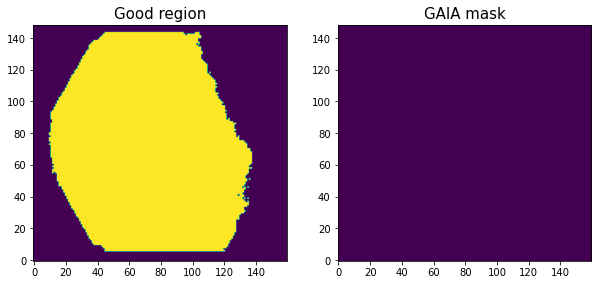

In [9]:
fig, axs = plt.subplots(1,2,figsize=(10,6))
axs[0].imshow(region,origin='lower')
axs[0].set_title('Good region',size=15)
axs[1].imshow(gaia,origin='lower')
axs[1].set_title('GAIA mask',size=15)
plt.show()

In [4]:
ssp = hdu_list[1].data

In [10]:
F_Ha = hdu_list[5].data[45]
F_Hb = hdu_list[5].data[28]

In [11]:
for i in range(len(ssp)):
    ssp[i][region<1] = np.nan
for frame in [F_Ha,F_Hb]:
    frame[region<1] = np.nan

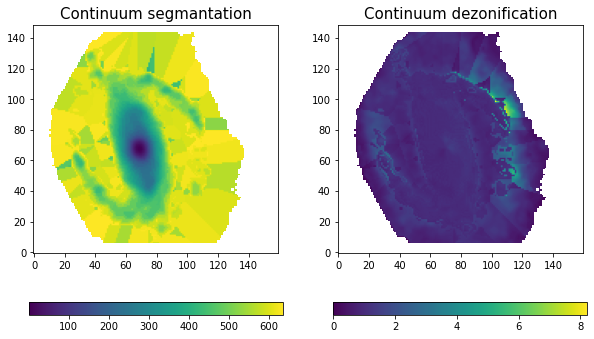

In [12]:
fig, axs = plt.subplots(1,2,figsize=(10,6))
for ax,frame,label in zip(axs.ravel(),[ssp[1],ssp[2]],['segmantation','dezonification']):
    im = ax.imshow(frame,origin='lower')
    fig.colorbar(im,ax=ax,orientation='horizontal')
    ax.set_title('Continuum '+label,size=15)
plt.show()

In [4]:
# check header for emission line flux and flux error indices
hdu_list[5].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                  160                                                  
NAXIS2  =                  149                                                  
NAXIS3  =                  432                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
CDELT3  =                  2.0                                                  
CRPIX3  =                  1.0                                                  
CRVAL3  =               3749.0                                                  
NAME0   = 'flux [OII]3727'                                                      
NAME1   = 'flux H12'        

In [9]:
#lines = [hdu_list[5].data[i] for i in [26,28,41,45,46,49,207,242,244,257,261,262,265,423]]
#lines = np.array(lines)
#frames[6] = -frames[6] # Ha emission line has negative EW, this makes it positive

In [ ]:
# flux_OIII5007 -> 0, eflux_OIII5007 -> 7
# flux_Hbeta    -> 1, eflux_Hbeta    -> 8
# flux_OI6300   -> 2, eflux_OI6300   -> 9
# flux_Halpha   -> 3, eflux_Halpha   -> 10
# flux_NII6584  -> 4, eflux_NII6584  -> 11
# flux_SII6717  -> 5, eflux_SII6717  -> 12
# EW_Halpha     -> 6, eEW_Halpha     -> 13

# V_band  -> 14
# M_star  -> 15
# segmentation
# dezonification

In [ ]:
theta_min = 5.4
theta_maj = 9.4
pa_beam = -36

/tmp/ipykernel_2218422/509080327.py:2: RuntimeWarning: divide by zero encountered in log10
  for ax,frame,label in zip(axs.ravel(),[ssp[18],ssp[19],ssp[19]+np.log10(ssp[2])],['',' (dust-corrected)',' (dezonification-corrected)']):


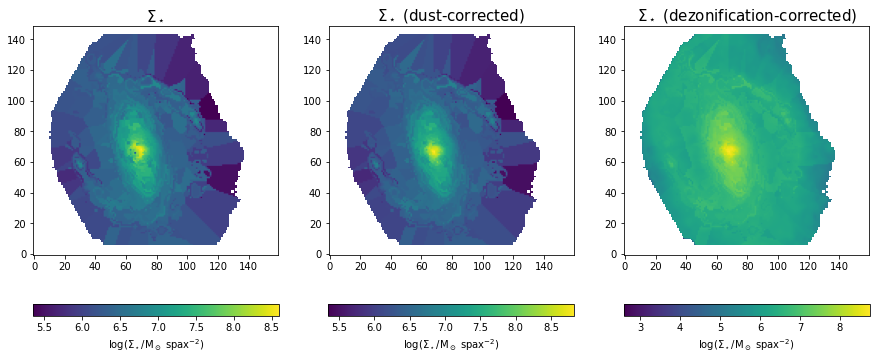

In [14]:
fig, axs = plt.subplots(1,3,figsize=(15,6))
for ax,frame,label in zip(axs.ravel(),[ssp[18],ssp[19],ssp[19]+np.log10(ssp[2])],['',' (dust-corrected)',' (dezonification-corrected)']):
    im = ax.imshow(frame,origin='lower')
    fig.colorbar(im,ax=ax,orientation='horizontal',label=r'log($\Sigma_\star$/M$_\odot$ spax$^{-2}$)')
    ax.set_title(r'$\Sigma_\star$'+label,size=15)
plt.show()

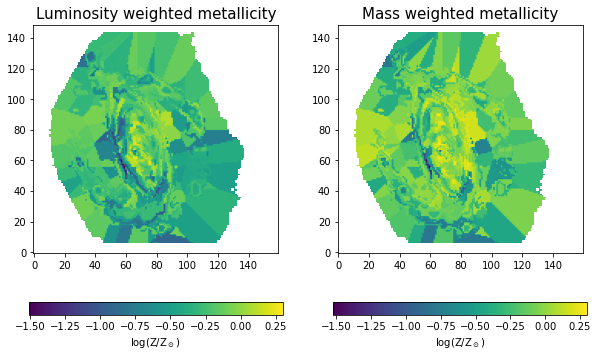

In [15]:
fig, axs = plt.subplots(1,2,figsize=(10,6))
for ax,frame,label in zip(axs.ravel(),[ssp[8],ssp[9]],['Luminosity','Mass']):
    im = ax.imshow(frame,origin='lower')
    fig.colorbar(im,ax=ax,orientation='horizontal',label=r'log(Z/Z$_\odot$) ')
    ax.set_title(label+' weighted metallicity',size=15)
plt.show()

In [16]:
Ha_to_Hb = np.where(F_Ha/F_Hb>2.86,F_Ha/F_Hb,2.86) # imposing minimum ratio of 2.86
Ha_to_Hb = np.where(np.isfinite(F_Ha),Ha_to_Hb,np.nan)

/tmp/ipykernel_2218422/2801910274.py:2: RuntimeWarning: invalid value encountered in log10
  for ax,frame,label in zip(axs.ravel(),[np.log10(F_Ha/F_Hb),np.log10(Ha_to_Hb),A_Ha],[r'H$\alpha$ flux',r'H$\beta$ flux',r'Extinction A$_{H\alpha}$']):


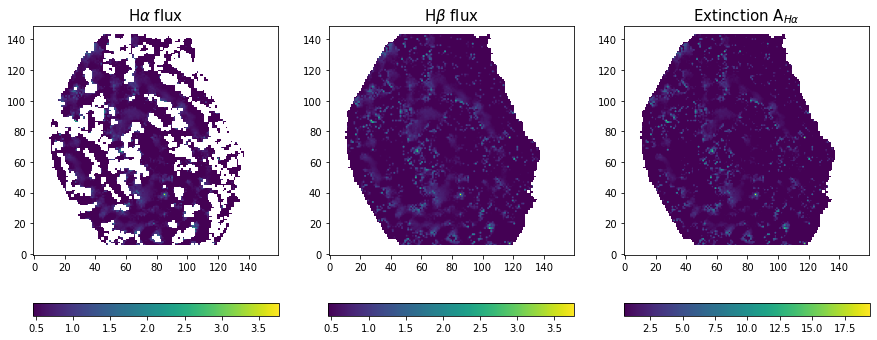

In [41]:
fig, axs = plt.subplots(1,3,figsize=(15,6))
for ax,frame,label in zip(axs.ravel(),[np.log10(F_Ha/F_Hb),np.log10(Ha_to_Hb),A_Ha],[r'H$\alpha$ flux',r'H$\beta$ flux',r'Extinction A$_{H\alpha}$']):
    im = ax.imshow(frame,origin='lower',vmin=0.4564)
    fig.colorbar(im,ax=ax,orientation='horizontal')
    ax.set_title(label,size=15)
plt.show()

In [17]:
A_Ha = 5.86*np.log10(Ha_to_Hb/2.86)
A_Ha_mean = np.nanmean(A_Ha[A_Ha>0])
A_Ha = np.where(np.isnan(F_Hb)&~np.isnan(F_Ha),A_Ha_mean,A_Ha)

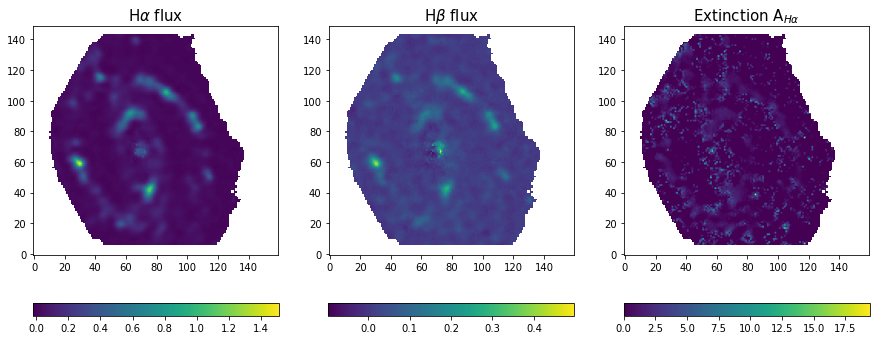

In [18]:
fig, axs = plt.subplots(1,3,figsize=(15,6))
for ax,frame,label in zip(axs.ravel(),[F_Ha,F_Hb,A_Ha],[r'H$\alpha$ flux',r'H$\beta$ flux',r'Extinction A$_{H\alpha}$']):
    im = ax.imshow(frame,origin='lower')
    fig.colorbar(im,ax=ax,orientation='horizontal')
    ax.set_title(label,size=15)
plt.show()

In [26]:
SFR = 1.61*7.9*(10**-42)*F_Ha*np.power(10,A_Ha/2.5) # 1.61 factor corrects from Salpeter to Kroupa IMF

In [19]:
from astropy.cosmology import FlatLambdaCDM, LambdaCDM
cosmo = LambdaCDM(H0=69.7,Om0=0.3,Ode0=0.7)

In [20]:
print(cosmo.luminosity_distance(0.02405))
print(cosmo.angular_diameter_distance(0.02405))

105.35514425989643 Mpc
100.4646839381213 Mpc


In [21]:
inclination = 53
PA = 12
z = 0.02405

In [22]:
D_lum = cosmo.luminosity_distance(z)
D_ang = cosmo.angular_diameter_distance(z)

In [70]:
hdu_list[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
HIERARCH PPAK P1 LONGSTRN = 'OGIP 1.0' / The HEASARC Long String Convention may 
HIERARCH PPAK P1 PVERSION = '1.0     ' / PMAS fitsheader version                
HIERARCH PPAK P1 FILENAME = 'run299_00085a.fits' / original filename            
HIERARCH PPAK P1 DATE = '2014-07-04T01:44:47' / file creation                   
HIERARCH PPAK P1 OBSERVER = 'Bergond -- van den Bosch'                          
HIERARCH PPAK P1 OBJECT = 'obj_6_p1_UGC12250'                                   
HIERARCH PPAK P1 CCD_TYPE = 'CCD231  '                                          
HIERARCH PPAK P1 NAMPS = 4 / Number of Amplifiers                               
HIERARCH PPAK P1 NCCDS = 1 /

In [72]:
WCS(hdu_list[0].header).celestial

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 343.8996960966434  12.78960500109381  
CRPIX : 69.0  63.0  
CD1_1 CD1_2  : -0.00013888888888888  0.0  
CD2_1 CD2_2  : 0.0  0.000138888888888888  
NAXIS : 0  0

In [23]:
pix_scale = (hdu_list[0].header['CDELT2']*u.deg).to(u.arcsec).value # spaxel size in arcsec

In [24]:
pix_area = ((pix_scale*D_ang/206265)**2).to(u.kpc**2)
pix_area

<Quantity 0.05930834 kpc2>

In [119]:
#S_SFR = SFR/pix_area.value

/tmp/ipykernel_2218422/2721496975.py:2: RuntimeWarning: invalid value encountered in log10
  for ax,frame,title,label in zip(axs.ravel(),[np.log10(SFR),np.log10(SFR/pix_area.value)],


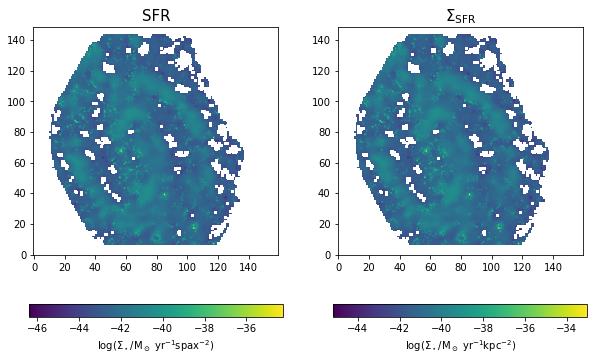

In [35]:
fig, axs = plt.subplots(1,2,figsize=(10,6))
for ax,frame,title,label in zip(axs.ravel(),[np.log10(SFR),np.log10(SFR/pix_area.value)],
                          ['SFR','$\Sigma_\mathrm{SFR}$'],[r'log($\Sigma_\star$/M$_\odot$ yr$^{-1} $spax$^{-2}$)',r'log($\Sigma_\star$/M$_\odot$ yr$^{-1} $kpc$^{-2}$)']):
    im = ax.imshow(frame,origin='lower')
    fig.colorbar(im,ax=ax,orientation='horizontal',label=label)
    ax.set_title(title,size=15)
#im = ax.imshow(,origin='lower')
#fig.colorbar(im,ax=ax,orientation='horizontal',label=r'log($\Sigma_\star$/M$_\odot$ yr$^{-1} $spax$^{-2}$)')
#ax.set_title(r'SFR',size=15)
plt.show()